# TASK 1: User Overview analysis

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append('../scripts')
from Clean_data import clean_data
from Extract_data import extract_data

In [3]:
# Import the dataset
df = pd.read_csv("../data/Cleaned_Data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 149010 non-null  float64
 1   Start                                     150000 non-null  object 
 2   Start ms                                  150001 non-null  float64
 3   End                                       150000 non-null  object 
 4   End ms                                    150001 non-null  float64
 5   Dur. (ms)                                 150001 non-null  float64
 6   IMSI                                      149431 non-null  float64
 7   MSISDN/Number                             148935 non-null  float64
 8   IMEI                                      149429 non-null  float64
 9   Last Location Name                        148848 non-null  object 
 10  Avg RTT DL (ms)     

## Sub-tasks

>## Identifying the top 10 handsets used by the customers </br>

The handsets type of the customers are stored in the column named `Handset Type`. But before extracting the information for this column, we should identify each unique user/customer. As a matter of fact, a customer can be identified by either his/her IMSI, MSISDN/number or IMEI.

In [4]:
# Search the column that have the less number of missing values
IdVariable = clean_data(df[['IMSI','MSISDN/Number', 'IMEI','Handset Type']])
missingCol,_,_ = IdVariable.missing_values(verbose=False)
missingCol

MSISDN/Number    1066
IMEI              572
Handset Type      572
IMSI              570
dtype: int64

Thus one can choose to use the `IMSI` to identify each customer because we get more information using this field instead of `IMEI` or `MSISDN/Number`. Nethertheless, one can also choose to use the `IMEI`. Since we're looking for the handset type, we can just focus on the **IMEI** because it's an unique number which identify a device on a mobile network. Furthermore, without the IMEI, we can't identify the handset type - this is the reason why we get the same number of missing values for those two columns. Even if, we get less missing values for IMSI, this caracteristics does not ensure that we'll get the maximum of information relative to the handset type.

In [5]:
def topN(df,col,topn,undefined=True):
    if undefined==False:
        topn = df.loc[df[col]!='undefined',col].value_counts()[:topn]
    else:
        topn = df.loc[:,col].value_counts()[:topn]
    return topn

In [6]:
# Extract the unique customer from the table
UniqueUser = df.loc[:,['IMEI','Handset Manufacturer','Handset Type']].dropna(how="all")
# Drop the duplicates
UniqueUser = UniqueUser.drop_duplicates()
# Count the number of each handset type and identify the top 10
topN(UniqueUser,'Handset Type',10)

Huawei B528S-23A                10638
Apple iPhone 6S (A1688)          6765
undefined                        6716
Apple iPhone 6 (A1586)           6271
Apple iPhone 7 (A1778)           4721
Apple iPhone Se (A1723)          3764
Apple iPhone 8 (A1905)           3550
Samsung Galaxy S8 (Sm-G950F)     3275
Apple iPhone Xr (A2105)          3077
Samsung Galaxy J5 (Sm-J530)      2760
Name: Handset Type, dtype: int64

In [7]:
# Count the number of each handset type and identify the top 10 (without undefined handset type)
topN(UniqueUser,'Handset Type',10,undefined=False)

Huawei B528S-23A                10638
Apple iPhone 6S (A1688)          6765
Apple iPhone 6 (A1586)           6271
Apple iPhone 7 (A1778)           4721
Apple iPhone Se (A1723)          3764
Apple iPhone 8 (A1905)           3550
Samsung Galaxy S8 (Sm-G950F)     3275
Apple iPhone Xr (A2105)          3077
Samsung Galaxy J5 (Sm-J530)      2760
Samsung Galaxy A5 Sm-A520F       2721
Name: Handset Type, dtype: int64

>## Identify the three top handset manufacturer

In [8]:
# Identify the top 3 manufacturer
topN(UniqueUser,'Handset Manufacturer',topn=3)

Apple      42687
Samsung    30981
Huawei     21743
Name: Handset Manufacturer, dtype: int64

>## Identify the top 5 handsets per top 3 handset manufacturer

In [9]:
# Function to extract the top n type of handset for the top m manufacturer
def topTypeManufact(df=UniqueUser,nmanufact=3,ntype=5):
    topNManufact = df.loc[:,'Handset Manufacturer'].value_counts()[:nmanufact]
    res = pd.DataFrame(columns=['Manufacturer','Type','Count'])
    for manufacturer in topNManufact.index:
        temp = df.loc[UniqueUser['Handset Manufacturer']==manufacturer,'Handset Type'].value_counts()[:ntype]
        temp = pd.DataFrame({'Manufacturer':[manufacturer]*ntype,'Type':temp.index,'Count':temp.to_list()})
        res = pd.concat([res,temp])
    return res.reset_index(drop=True)

In [10]:
# Identify the top 5 handsets per top 3 handset manufacturer
topTypeManufact(df=UniqueUser,nmanufact=3,ntype=5)

,Manufacturer,Type,Count
0,Apple,Apple iPhone 6S (A1688),6765
1,Apple,Apple iPhone 6 (A1586),6271
2,Apple,Apple iPhone 7 (A1778),4721
3,Apple,Apple iPhone Se (A1723),3764
4,Apple,Apple iPhone 8 (A1905),3550
5,Samsung,Samsung Galaxy S8 (Sm-G950F),3275
6,Samsung,Samsung Galaxy J5 (Sm-J530),2760
7,Samsung,Samsung Galaxy A5 Sm-A520F,2721
8,Samsung,Samsung Galaxy J3 (Sm-J330),2606
9,Samsung,Samsung Galaxy S7 (Sm-G930X),2310


>## Task 1.1: Get an overview of the users’ behavior on those applications

In [11]:
dfData = df.loc[:,['Bearer Id','Dur. (ms)','IMSI','Social Media DL (Bytes)','Social Media UL (Bytes)',
                                  'Google DL (Bytes)', 'Google UL (Bytes)', 'Email DL (Bytes)',
                                  'Email UL (Bytes)', 'Youtube DL (Bytes)', 'Youtube UL (Bytes)',
                                  'Netflix DL (Bytes)', 'Netflix UL (Bytes)', 'Gaming DL (Bytes)',
                                  'Gaming UL (Bytes)', 'Other DL (Bytes)', 'Other UL (Bytes)',
                                  'Total UL (Bytes)', 'Total DL (Bytes)']]

In [12]:
DataByte = extract_data(dfData)

In [44]:
DataUser = DataByte.merge_data('IMSI')
DataUser

,Number of session,Duration (s),Social Media,Google,Email,Youtube,Gaming,Other,Total
IMSI,,,,,,,,,
2.040471e+14,1,104608.560347,1546088.0,9218647.0,3330974.0,40940710.0,43070260.0,4.013605e+08,1.391536e+08
2.040808e+14,1,104608.560347,715224.0,10438660.0,1520771.0,11959905.0,178048738.0,4.705265e+08,2.321240e+08
2.082001e+14,1,86019.000000,3122781.0,1624662.0,3657501.0,19882439.0,9124516.0,5.159737e+08,8.517164e+07
2.082001e+14,1,86254.000000,2577104.0,13811478.0,3855734.0,25657632.0,344105897.0,3.096107e+08,4.265016e+08
2.082001e+14,2,287894.560347,3426716.0,11665887.0,5564462.0,13840201.0,917684766.0,1.079435e+09,1.033092e+09
...,...,...,...,...,...,...,...,...,...
2.082099e+14,1,127367.000000,1256603.0,12047606.0,956312.0,11621474.0,678493990.0,5.883943e+08,7.227036e+08
2.082099e+14,1,168543.000000,3465755.0,4287813.0,2284566.0,34857460.0,411382679.0,7.526239e+08,4.958656e+08
2.082099e+14,1,86399.000000,2609666.0,4427934.0,1717645.0,29190696.0,272046636.0,4.567354e+08,3.381806e+08


In [45]:
# Function to convert seconds into hours
def convert_sec_to_hour(df,duration_col):
    """This function converts the duration (s) into hours"""
    hour = 3600
    df.loc[:,duration_col] = df.loc[:,duration_col]/hour
    return df.loc[:,duration_col]

In [46]:
DataUser.loc[:,"Duration (s)"] = convert_sec_to_hour(DataUser,"Duration (s)")
DataUser.rename(columns={'Duration (s)':'Duration (hrs)'})
DataUser

,Number of session,Duration (s),Social Media,Google,Email,Youtube,Gaming,Other,Total
IMSI,,,,,,,,,
2.040471e+14,1,29.057933,1546088.0,9218647.0,3330974.0,40940710.0,43070260.0,4.013605e+08,1.391536e+08
2.040808e+14,1,29.057933,715224.0,10438660.0,1520771.0,11959905.0,178048738.0,4.705265e+08,2.321240e+08
2.082001e+14,1,23.894167,3122781.0,1624662.0,3657501.0,19882439.0,9124516.0,5.159737e+08,8.517164e+07
2.082001e+14,1,23.959444,2577104.0,13811478.0,3855734.0,25657632.0,344105897.0,3.096107e+08,4.265016e+08
2.082001e+14,2,79.970711,3426716.0,11665887.0,5564462.0,13840201.0,917684766.0,1.079435e+09,1.033092e+09
...,...,...,...,...,...,...,...,...,...
2.082099e+14,1,35.379722,1256603.0,12047606.0,956312.0,11621474.0,678493990.0,5.883943e+08,7.227036e+08
2.082099e+14,1,46.817500,3465755.0,4287813.0,2284566.0,34857460.0,411382679.0,7.526239e+08,4.958656e+08
2.082099e+14,1,23.999722,2609666.0,4427934.0,1717645.0,29190696.0,272046636.0,4.567354e+08,3.381806e+08


In [14]:
DataApp = DataUser[['Social Media','Google','Email','Youtube','Gaming','Other','Total']]

In [21]:
# Function to convert into Mbytes
def convert_bytes_to_megabytes(df, bytes_data):
    """
        This function takes the dataframe and the column which has the bytes values
        returns the megabytesof that value
        
        Args:
        -----
        df: dataframe
        bytes_data: column with bytes values
        
        Returns:
        --------
        A series
    """
    
    megabyte = 1*10e+5
    df.loc[:,bytes_data] = df.loc[:,bytes_data] / megabyte
    return df.loc[:,bytes_data]

In [22]:
DataAppMb = convert_bytes_to_megabytes(DataApp,['Social Media','Google','Email','Youtube','Gaming','Other','Total'])

C:\Users\sedam\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\sedam\anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [23]:
# FUNCTION FOR PLOTTING
def plot_hist(df:pd.DataFrame, column:str, color:str)->None:
    # plt.figure(figsize=(15, 10))
    # fig, ax = plt.subplots(1, figsize=(12, 7))
    sns.displot(data=df, x=column, color=color, kde=True, height=7, aspect=2)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

def plot_count(df:pd.DataFrame, column:str) -> None:
    plt.figure(figsize=(12, 7))
    sns.countplot(data=df, x=column)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

In [25]:
DataAppMb

,Social Media,Google,Email,Youtube,Gaming,Other,Total
IMSI,,,,,,,
2.040471e+14,1.546088e-06,0.000009,3.330974e-06,0.000041,0.000043,0.000401,0.000139
2.040808e+14,7.152240e-07,0.000010,1.520771e-06,0.000012,0.000178,0.000471,0.000232
2.082001e+14,3.122781e-06,0.000002,3.657501e-06,0.000020,0.000009,0.000516,0.000085
2.082001e+14,2.577104e-06,0.000014,3.855734e-06,0.000026,0.000344,0.000310,0.000427
2.082001e+14,3.426716e-06,0.000012,5.564462e-06,0.000014,0.000918,0.001079,0.001033
...,...,...,...,...,...,...,...
2.082099e+14,1.256603e-06,0.000012,9.563120e-07,0.000012,0.000678,0.000588,0.000723
2.082099e+14,3.465755e-06,0.000004,2.284566e-06,0.000035,0.000411,0.000753,0.000496
2.082099e+14,2.609666e-06,0.000004,1.717645e-06,0.000029,0.000272,0.000457,0.000338


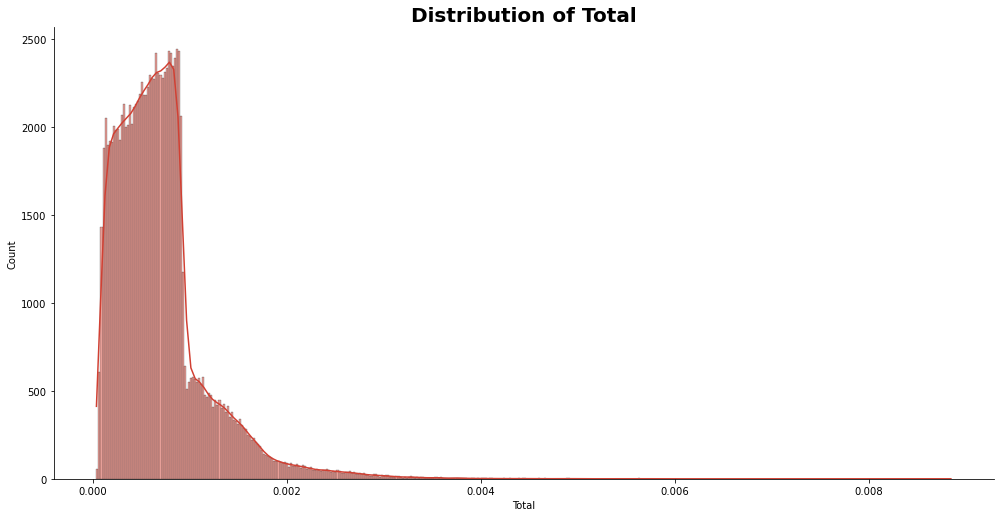

In [33]:
plot_hist(DataAppMb,'Total',"#d14033")

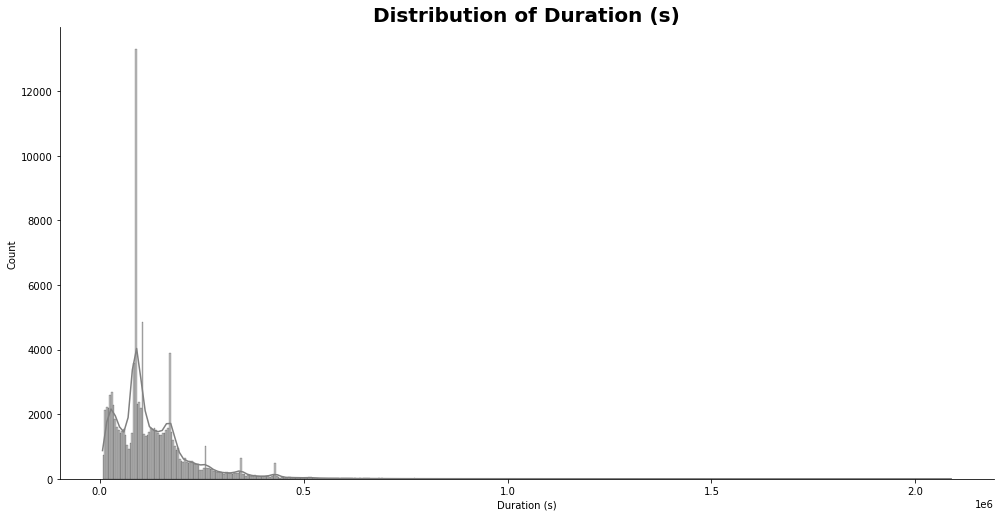

In [36]:
plot_hist(DataUser,"Duration (s)","grey")

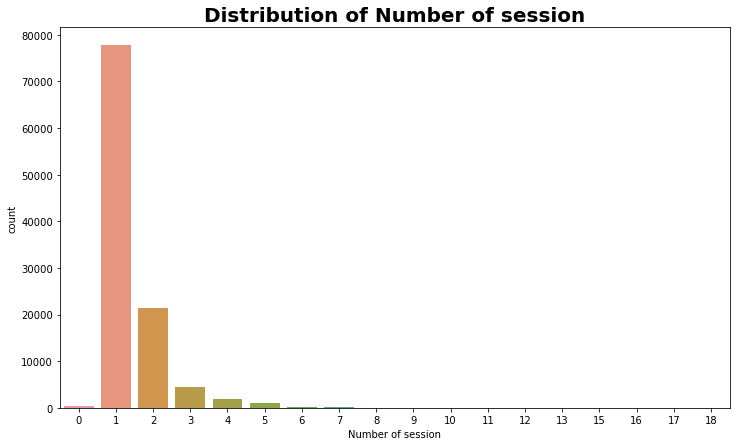

In [35]:
plot_count(DataUser,"Number of session")

In [31]:
pd.DataFrame(np.corrcoef(DataAppMb,rowvar=False),columns=DataAppMb.columns,index=DataAppMb.columns)

,Social Media,Google,Email,Youtube,Gaming,Other,Total
Social Media,1.000000,0.643044,0.634060,0.659516,0.590021,0.591808,0.623921
Google,0.643044,1.000000,0.688418,0.718448,0.641956,0.642544,0.681641
Email,0.634060,0.688418,1.000000,0.704659,0.627519,0.631049,0.663825
Youtube,0.659516,0.718448,0.704659,1.000000,0.657449,0.660284,0.705035
Gaming,0.590021,0.641956,0.627519,0.657449,1.000000,0.586485,0.997005
Other,0.591808,0.642544,0.631049,0.660284,0.586485,1.000000,0.619108
Total,0.623921,0.681641,0.663825,0.705035,0.997005,0.619108,1.000000
